# Machine Learning Lab – 15 Questions

All solutions in a single notebook. Uses only `numpy`, `pandas`, `matplotlib`, `scikit-learn` (and optional `scipy` for dendrogram).

In [1]:

# === Common Imports ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Make plots a bit larger
plt.rcParams["figure.figsize"] = (6,4)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import (r2_score, mean_squared_error, mean_absolute_error,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, roc_curve, auc, jaccard_score)
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA

# Optional: SciPy for dendrogram (only used if available)
try:
    from scipy.cluster.hierarchy import dendrogram, linkage
    SCIPY_OK = True
except Exception:
    SCIPY_OK = False

import os

RANDOM_STATE = 42

# === Small helpers ===
def ensure_csv_or_make(df, fname):
    # If fname exists, return pd.read_csv(fname); else save df to fname then read+return.
    if os.path.exists(fname):
        return pd.read_csv(fname)
    else:
        df.to_csv(fname, index=False)
        return df

def plot_actual_vs_pred(y_true, y_pred, title="Actual vs Predicted"):
    plt.figure()
    plt.scatter(y_true, y_pred, alpha=0.7)
    mn = min(y_true.min(), y_pred.min())
    mx = max(y_true.max(), y_pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.show()

def print_regression_metrics(y_true, y_pred):
    print("R2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", mean_squared_error(y_true, y_pred, squared=False))

def plot_confusion_matrix_basic(cm, class_names=None, title="Confusion Matrix"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    import numpy as _np
    tick_marks = _np.arange(cm.shape[0])
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


## Q1) Linear Regression – CO₂ Emission & Used Car Price

=== CO2 Emission – Linear Regression ===
R2: 0.9336593456033768
MAE: 7.9871006495749395
RMSE: 10.394021539307778


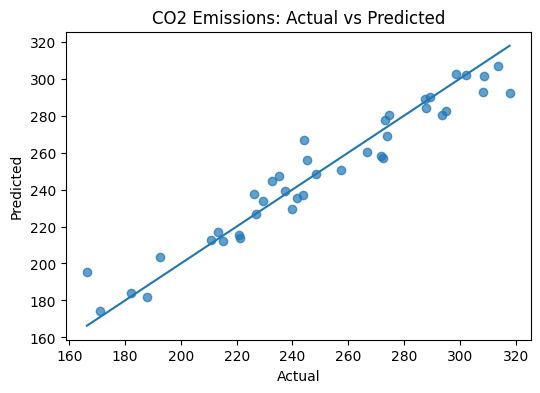


=== Used Car Price – Linear Regression ===
R2: 0.9604456330808712
MAE: 43191.824999207674
RMSE: 53756.870840998956


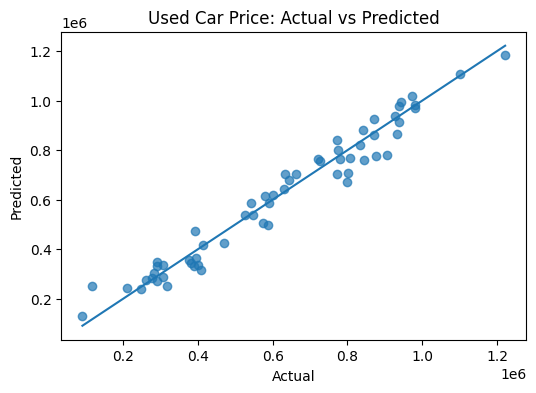

In [3]:
# ----- Helper Function (fixed RMSE) -----
def print_regression_metrics(y_true, y_pred):
    print("R2:", r2_score(y_true, y_pred))
    print("MAE:", mean_absolute_error(y_true, y_pred))
    rmse = mean_squared_error(y_true, y_pred) ** 0.5   # FIXED ✅
    print("RMSE:", rmse)


# --- Task 1A: CO2 Emission prediction ---
fname = "fuel_consumption_dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 200
    eng_size = np.random.uniform(1.0, 5.0, size=n)
    cyl = np.random.choice([4,6,8], size=n, p=[0.5,0.3,0.2])
    fuel_comb = 4 + 2*eng_size + 0.3*cyl + np.random.normal(0, 0.5, size=n)
    co2 = 90 + 20*eng_size + 8*cyl + 5*fuel_comb + np.random.normal(0, 10, size=n)
    df = pd.DataFrame({
        "ENG_SIZE": eng_size,
        "CYLINDERS": cyl,
        "FUELCONSUMPTION_COMB": fuel_comb,
        "CO2EMISSIONS": co2
    })
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.drop(columns=[data.columns[-1]])
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print("=== CO2 Emission – Linear Regression ===")
print_regression_metrics(y_test, pred)
plot_actual_vs_pred(y_test.values, pred, title="CO2 Emissions: Actual vs Predicted")


# --- Task 1B: Used Car Price prediction ---
fname = "used_cars_dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 300
    age = np.random.randint(1, 15, size=n)
    mileage = np.random.randint(5000, 200000, size=n)
    brand = np.random.choice(["A","B","C","D"], size=n)
    brand_map = {"A":0, "B":1, "C":2, "D":3}
    brand_enc = np.vectorize(brand_map.get)(brand)
    price = 1200000 - 60000*age - 1.5*mileage + 30000*brand_enc + np.random.normal(0, 50000, size=n)
    df2 = pd.DataFrame({"age":age, "mileage":mileage, "brand":brand, "brand_enc":brand_enc, "price":price})
    df2 = ensure_csv_or_make(df2, fname)

data2 = pd.read_csv(fname)
if "price" in data2.columns:
    target_col = "price"
else:
    target_col = data2.columns[-1]

X2 = data2.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")
y2 = data2[target_col]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=RANDOM_STATE)
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
pred2 = lr2.predict(X2_test)

print("\n=== Used Car Price – Linear Regression ===")
print_regression_metrics(y2_test, pred2)
plot_actual_vs_pred(y2_test.values, pred2, title="Used Car Price: Actual vs Predicted")


## Q2) L1 (Lasso) & L2 (Ridge) – Housing Price

=== Lasso Best R2: 0.9998480437432694 alpha: 100.0


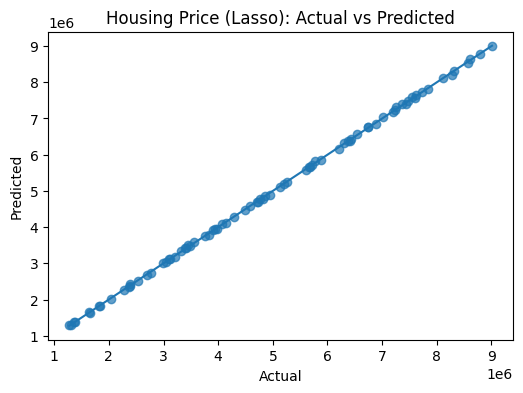


=== Ridge Best R2: 0.9998483686604333 alpha: 7.742636826811277


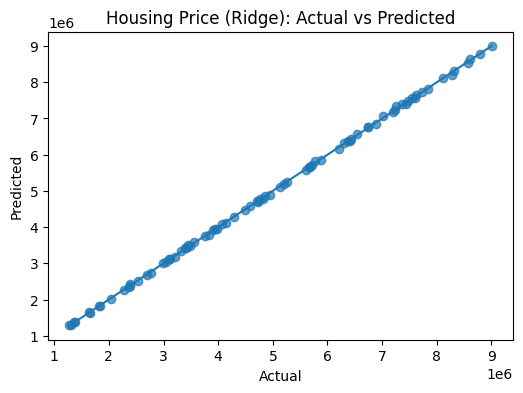

In [4]:

fname = "housing_price_dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 400
    rooms = np.random.randint(1, 6, size=n)
    area = np.random.randint(300, 3000, size=n)
    age = np.random.randint(0, 50, size=n)
    price = 50000*rooms + 3000*area - 8000*age + np.random.normal(0, 30000, size=n)
    df = pd.DataFrame({"rooms":rooms, "area":area, "age":age, "price":price})
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.drop(columns=[data.columns[-1]])
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

alphas = np.logspace(-3, 2, 10)

best_lasso = None
best_r2_lasso = -np.inf
for a in alphas:
    model = Lasso(alpha=a, random_state=RANDOM_STATE, max_iter=10000)
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    if r2 > best_r2_lasso:
        best_r2_lasso, best_lasso = r2, model

best_ridge = None
best_r2_ridge = -np.inf
for a in alphas:
    model = Ridge(alpha=a, random_state=RANDOM_STATE, max_iter=10000)
    model.fit(X_train, y_train)
    r2 = r2_score(y_test, model.predict(X_test))
    if r2 > best_r2_ridge:
        best_r2_ridge, best_ridge = r2, model

print("=== Lasso Best R2:", best_r2_lasso, "alpha:", best_lasso.alpha)
pred_lasso = best_lasso.predict(X_test)
plot_actual_vs_pred(y_test.values, pred_lasso, title="Housing Price (Lasso): Actual vs Predicted")

print("\n=== Ridge Best R2:", best_r2_ridge, "alpha:", best_ridge.alpha)
pred_ridge = best_ridge.predict(X_test)
plot_actual_vs_pred(y_test.values, pred_ridge, title="Housing Price (Ridge): Actual vs Predicted")


## Q3) Linear Regression with One Feature using Gradient Descent (No library) – Salary vs Years Experience

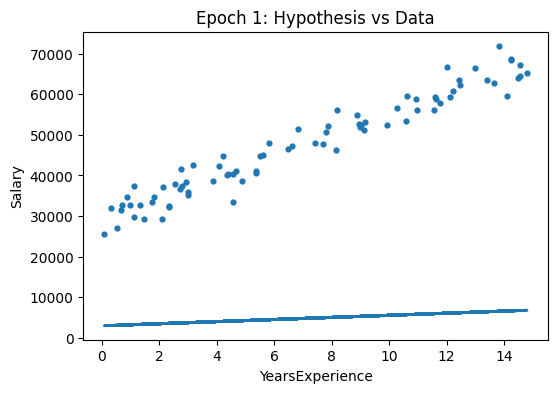

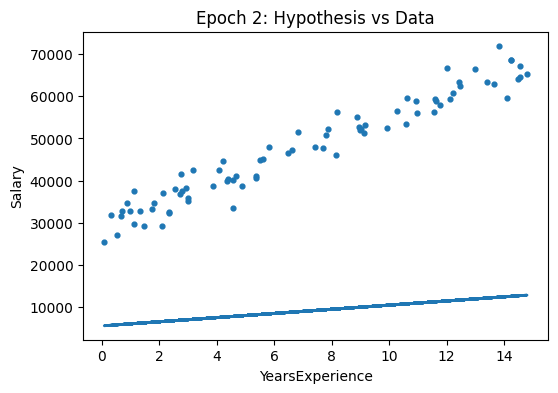

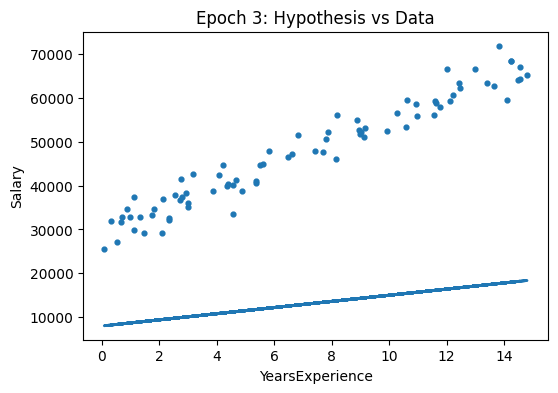

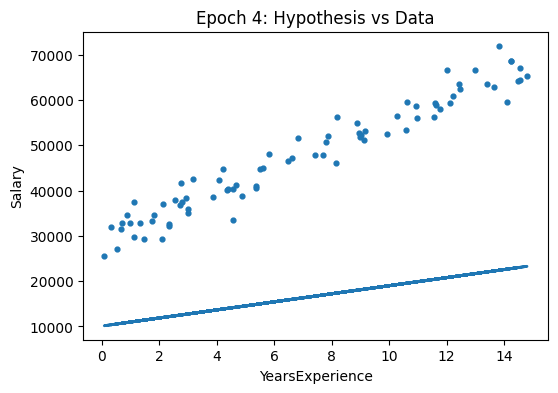

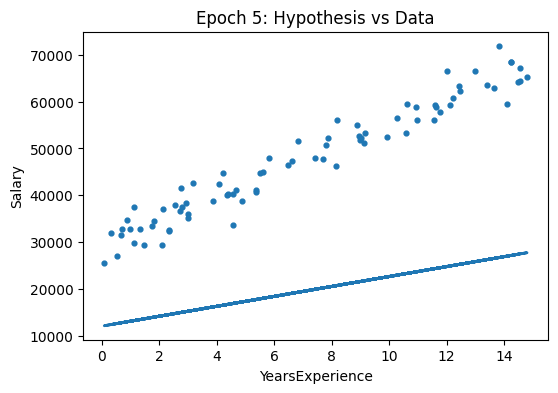

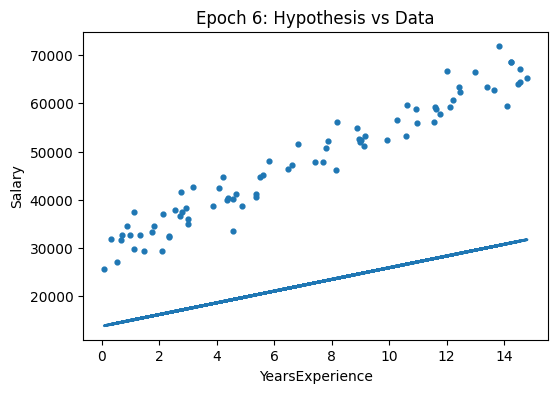

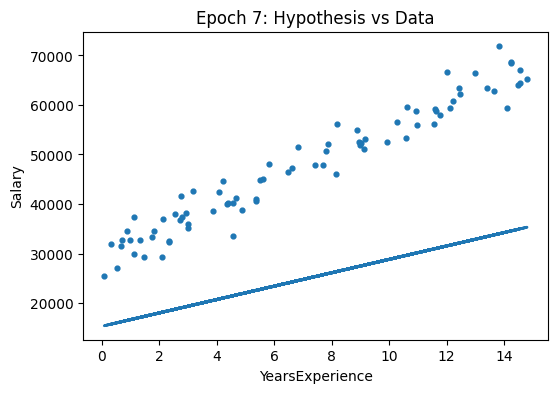

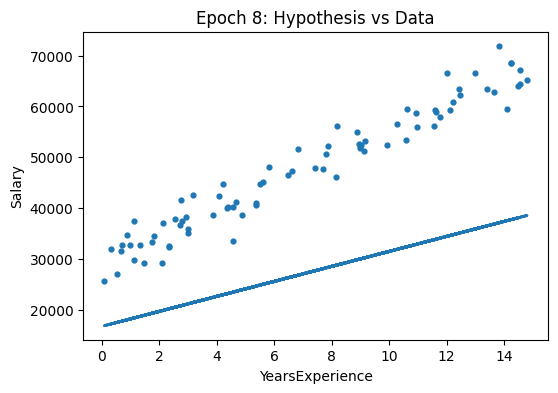

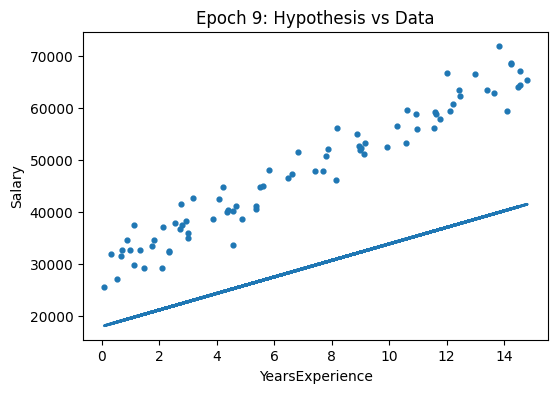

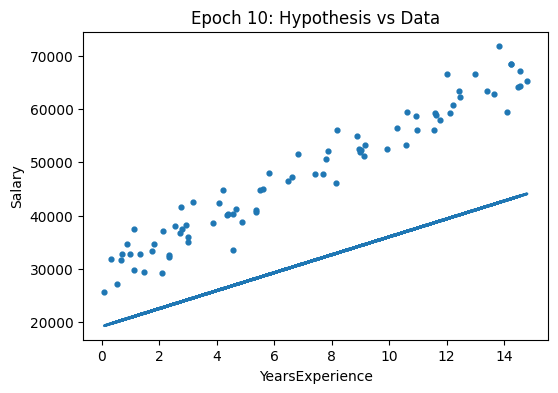

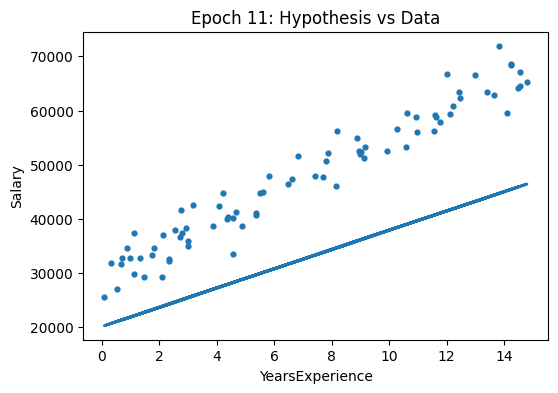

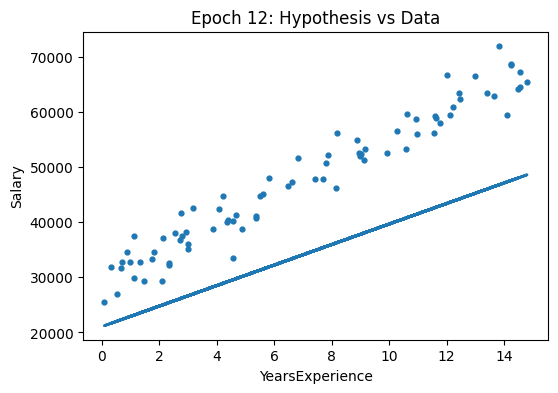

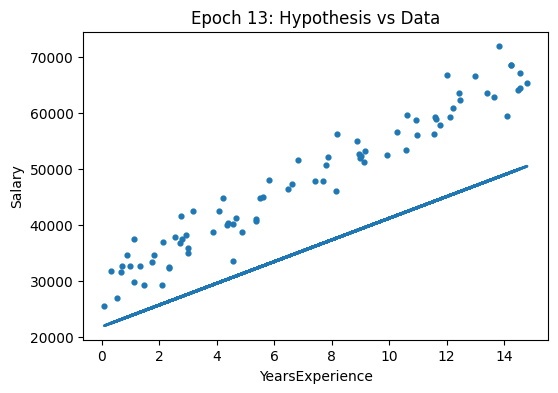

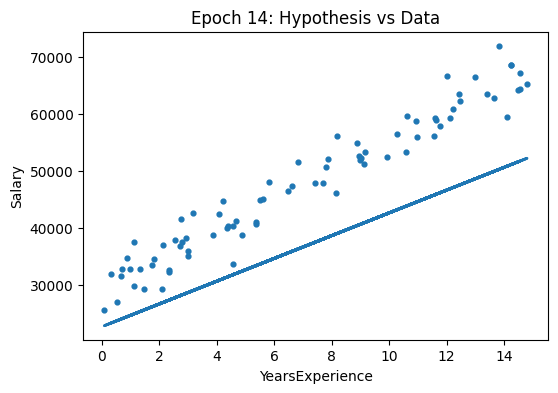

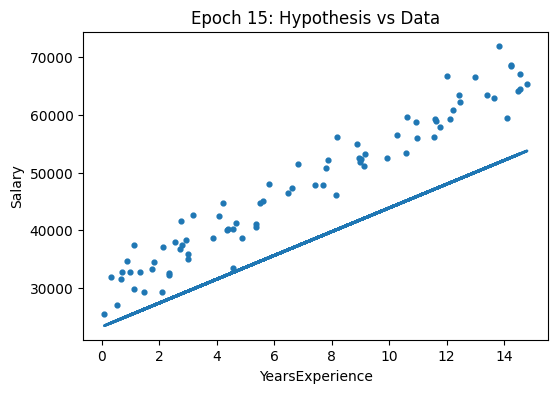

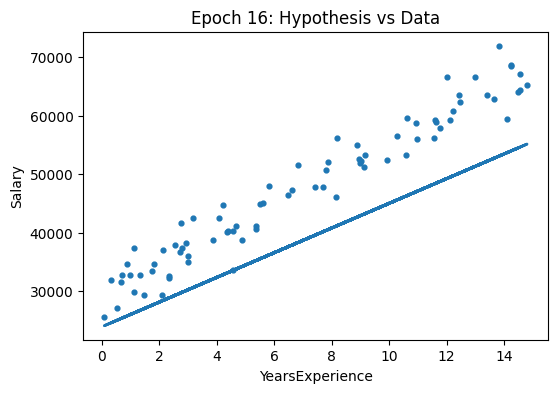

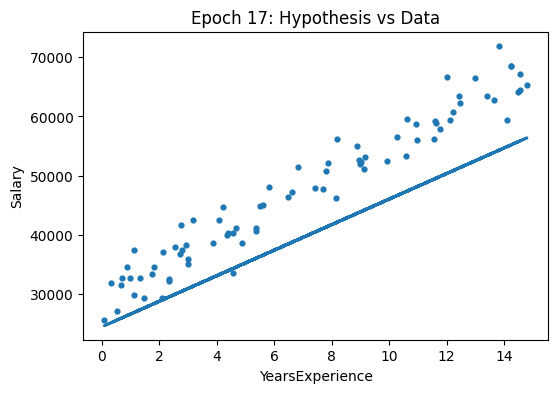

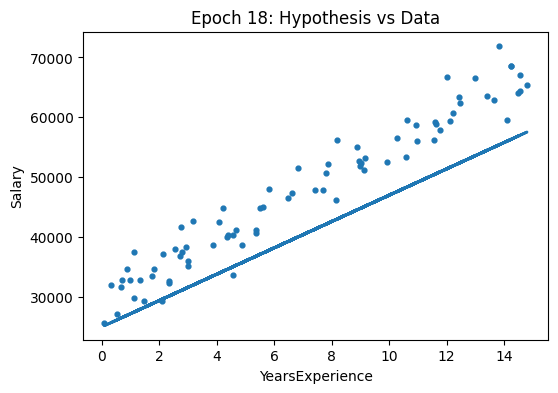

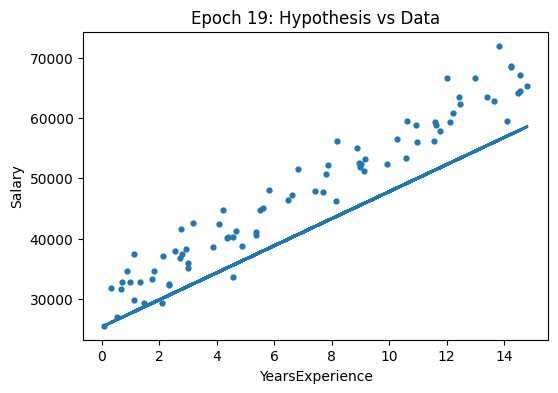

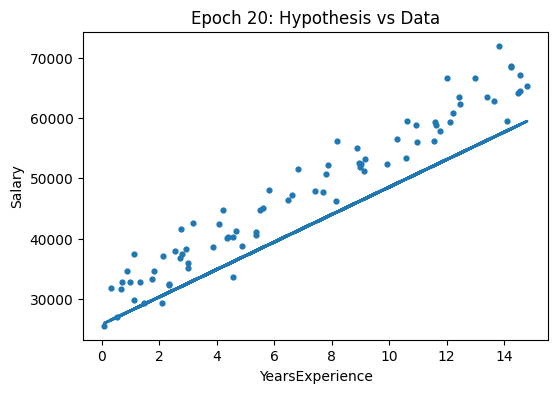

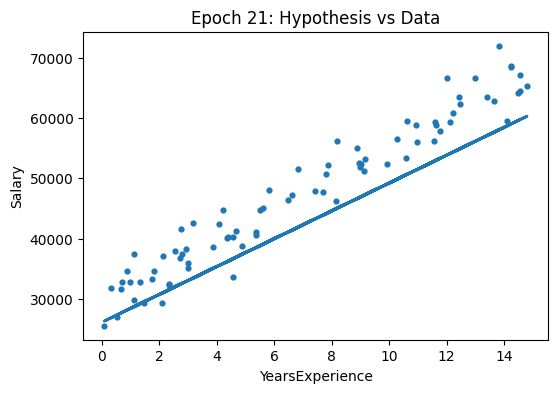

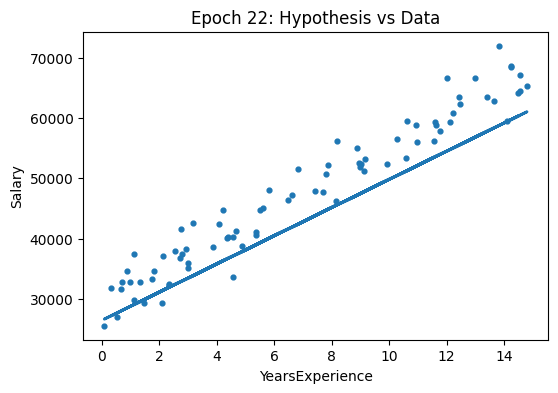

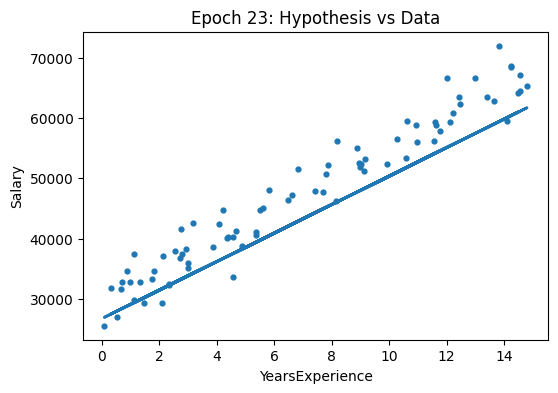

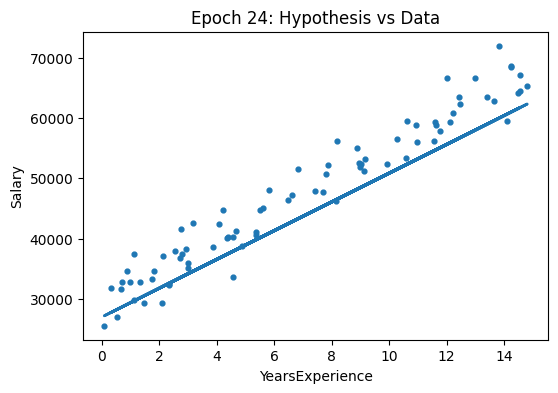

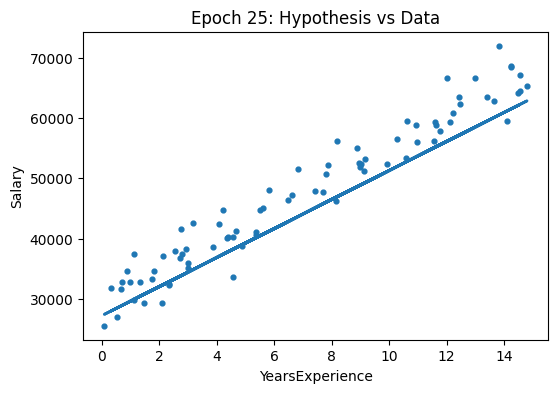

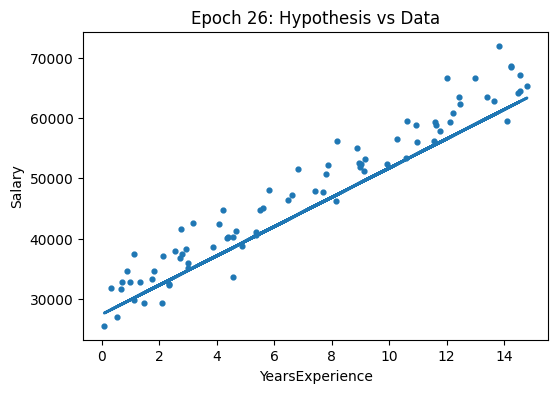

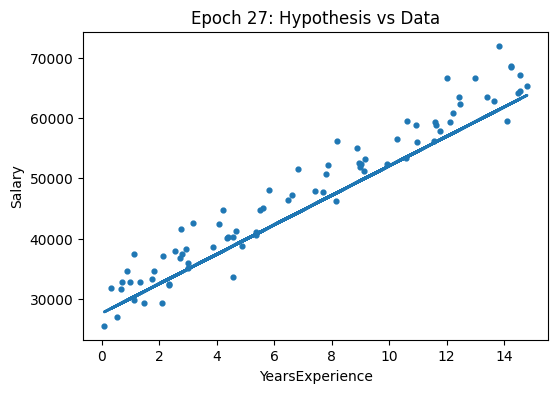

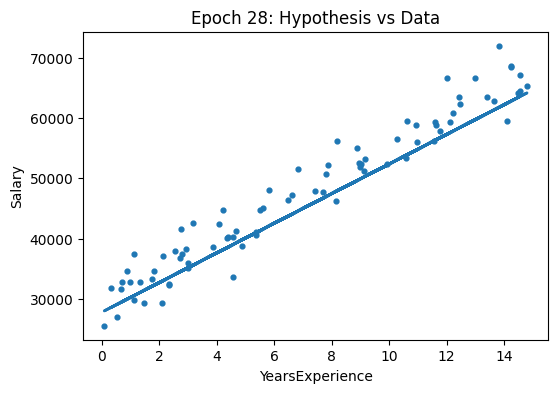

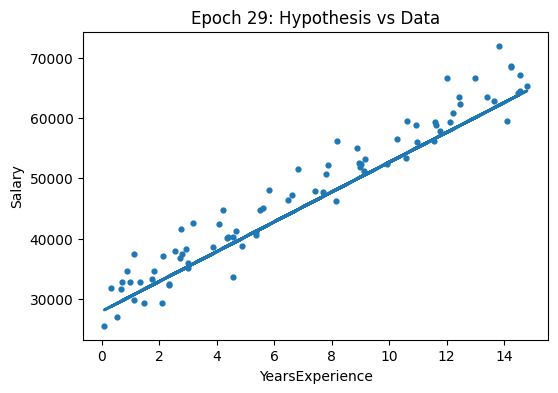

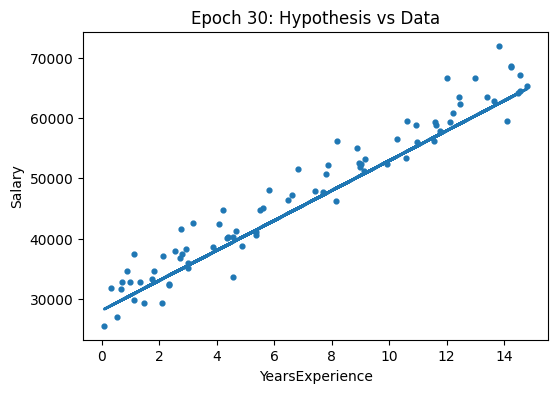

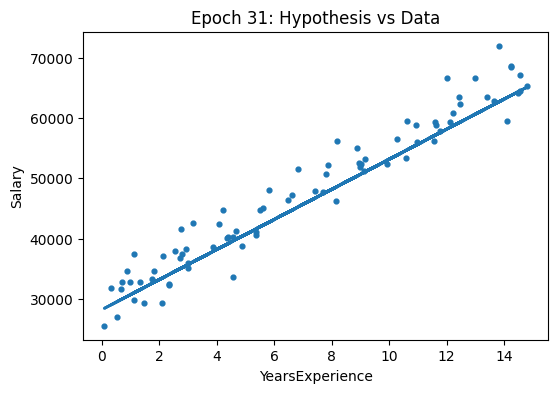

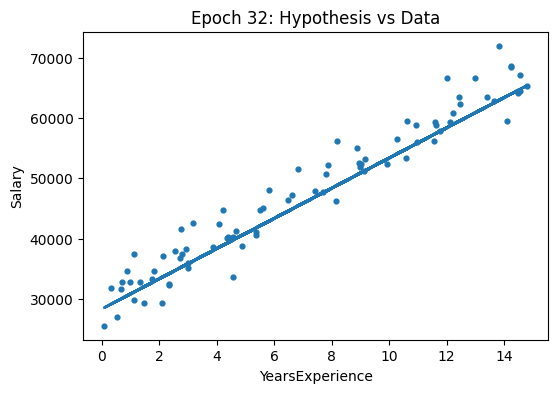

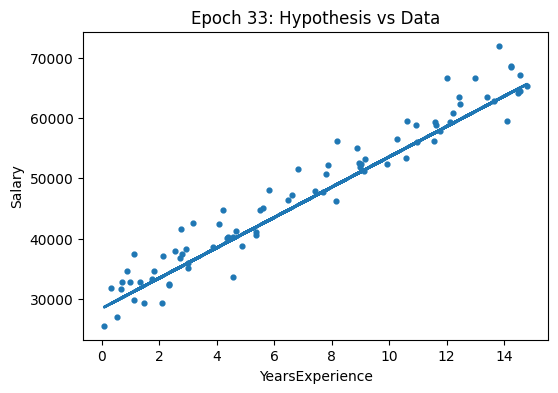

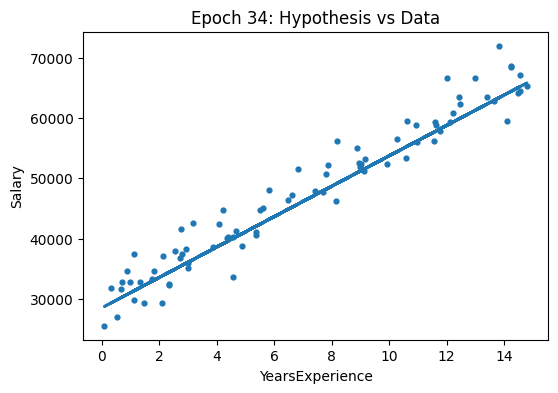

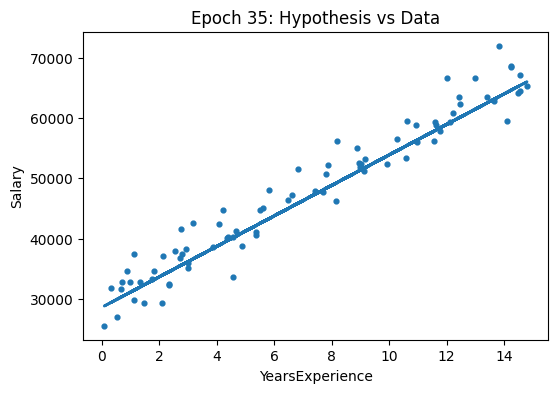

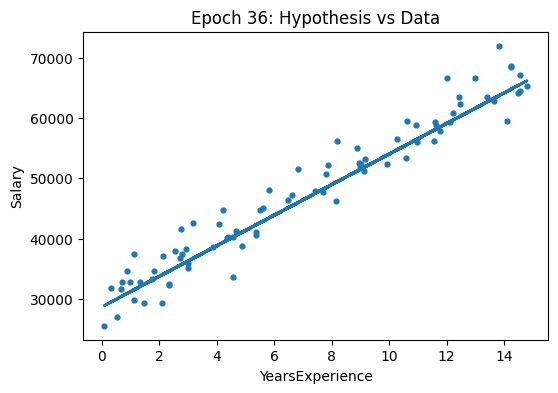

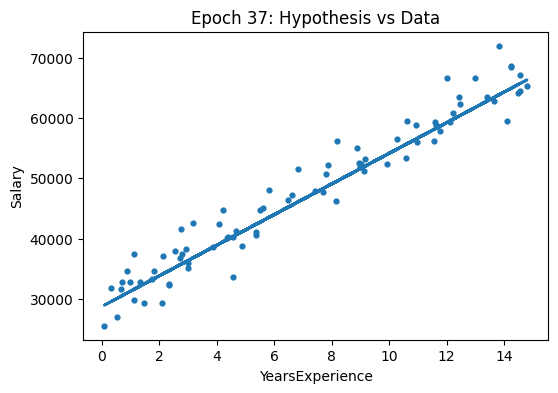

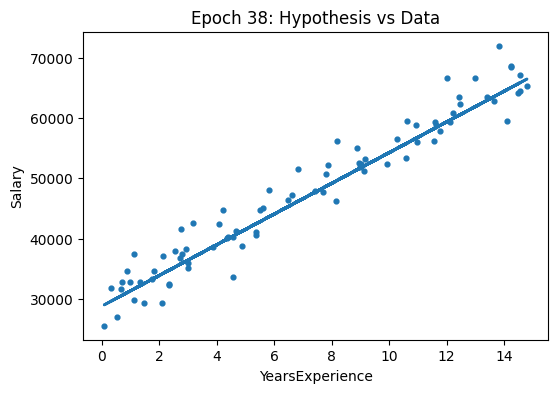

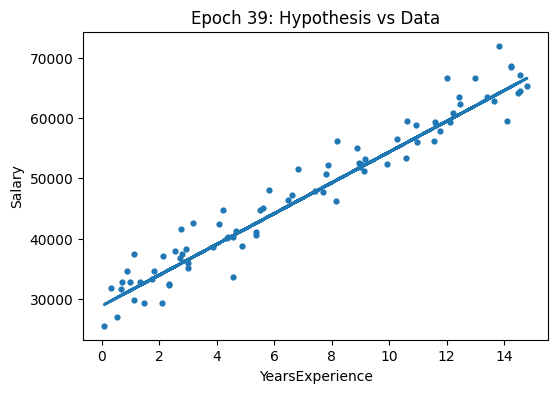

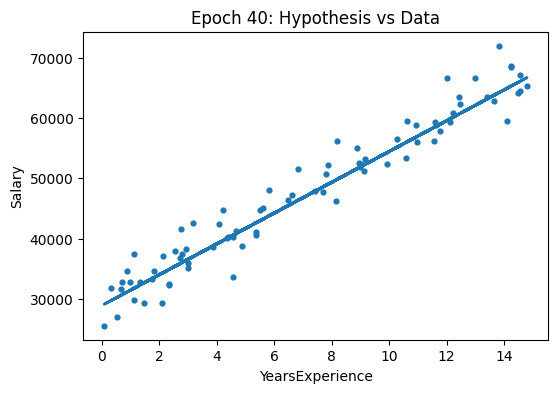

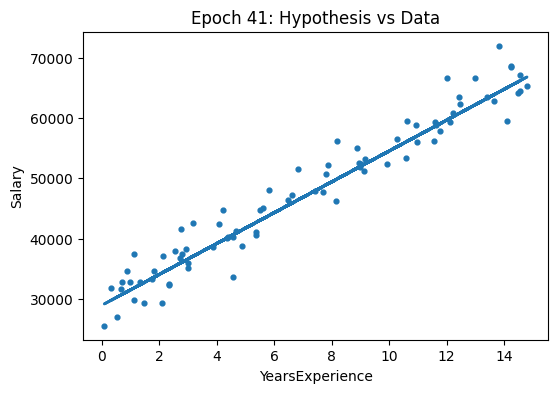

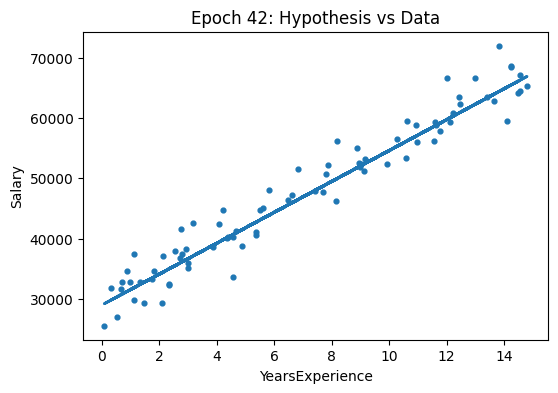

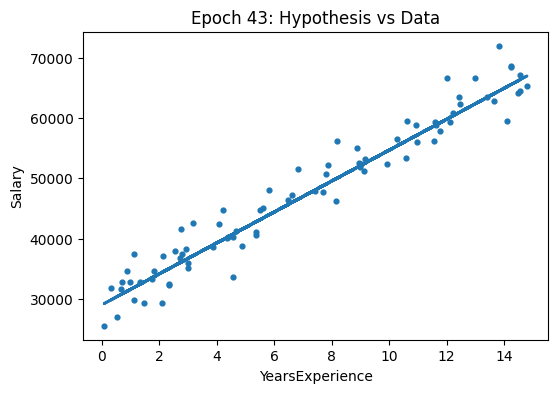

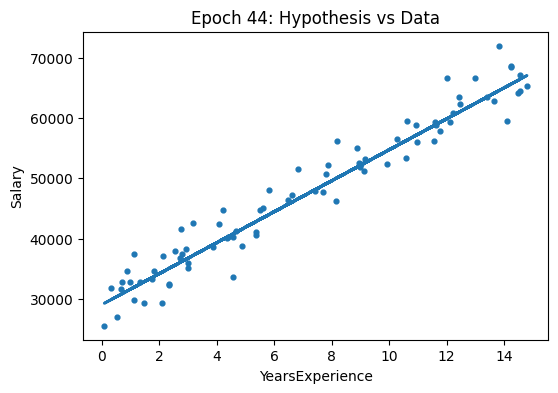

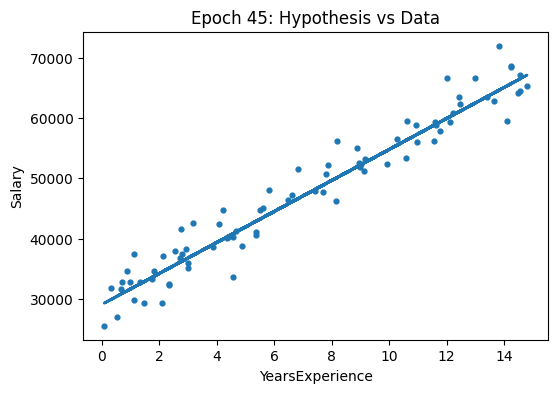

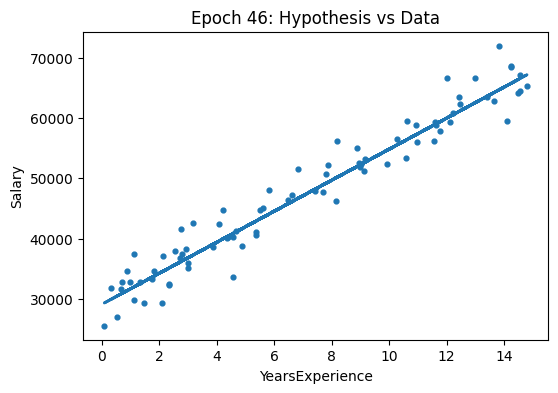

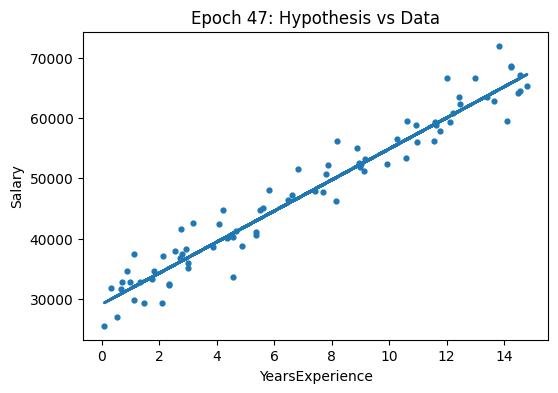

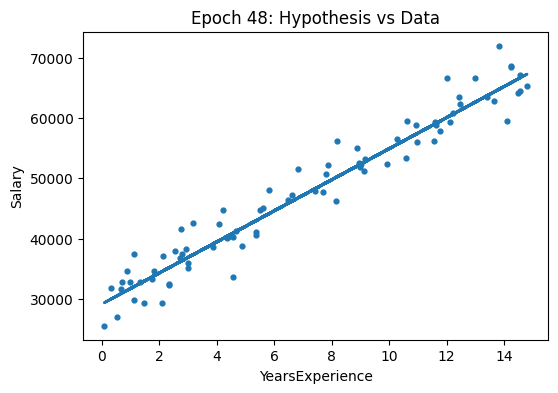

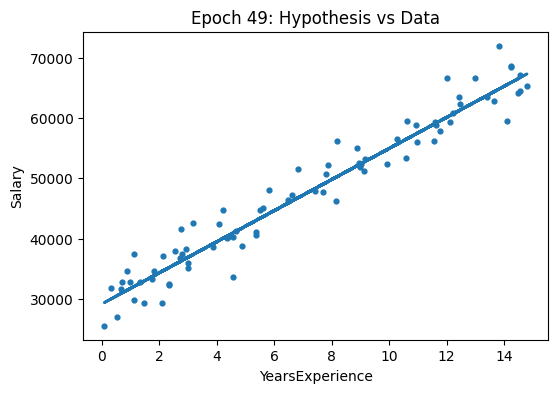

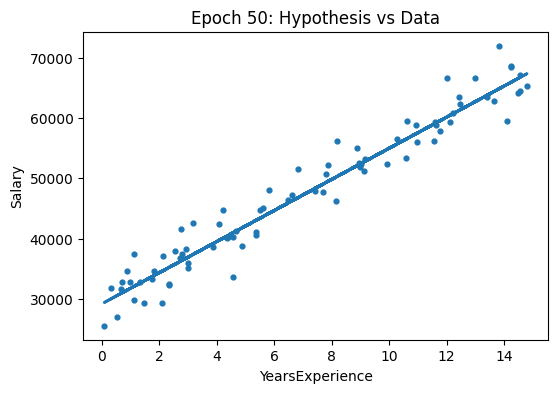

Final R2: 0.9446837130737443
MAE: 2222.897995068222


TypeError: got an unexpected keyword argument 'squared'

In [5]:

fname = "salary_dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 80
    Xs = np.random.uniform(0, 15, size=n)
    ys = 30000 + 2500*Xs + np.random.normal(0, 3000, size=n)
    df = pd.DataFrame({"YearsExperience": Xs, "Salary": ys})
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
x = data.iloc[:, 0].values.reshape(-1,1).astype(float)
y = data.iloc[:, 1].values.astype(float)

x_mu, x_sigma = x.mean(), x.std()
x_norm = (x - x_mu)/x_sigma

theta0 = 0.0
theta1 = 0.0
alpha = 0.1
epochs = 50

def predict(xn):
    return theta0 + theta1 * xn

loss_history = []

for epoch in range(epochs):
    y_hat = predict(x_norm.flatten())
    error = y_hat - y
    d0 = error.mean()
    d1 = (error * x_norm.flatten()).mean()
    theta0 -= alpha * d0
    theta1 -= alpha * d1

    mse = ((y_hat - y)**2).mean()
    loss_history.append(mse)

    plt.figure()
    plt.scatter(x.flatten(), y, s=12)
    y_line = (theta0 + theta1 * ((x - x_mu)/x_sigma)).flatten()
    plt.plot(x.flatten(), y_line, linewidth=2)
    plt.title(f"Epoch {epoch+1}: Hypothesis vs Data")
    plt.xlabel("YearsExperience")
    plt.ylabel("Salary")
    plt.show()

y_pred_final = (theta0 + theta1 * ((x - x_mu)/x_sigma)).flatten()
print("Final R2:", r2_score(y, y_pred_final))
print("MAE:", mean_absolute_error(y, y_pred_final))
print("RMSE:", mean_squared_error(y, y_pred_final, squared=False))

plt.figure()
plt.plot(loss_history)
plt.title("MSE Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()


## Q4) Non-linear Regression – China GDP (Polynomial Regression)

R2: 0.9880580319158478
MAE: 360.65220122090193
RMSE: 414.7096794714821


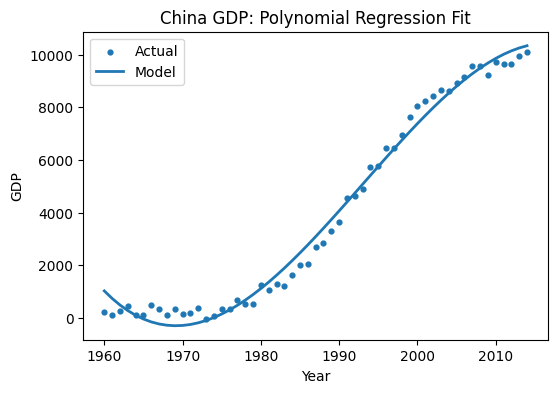

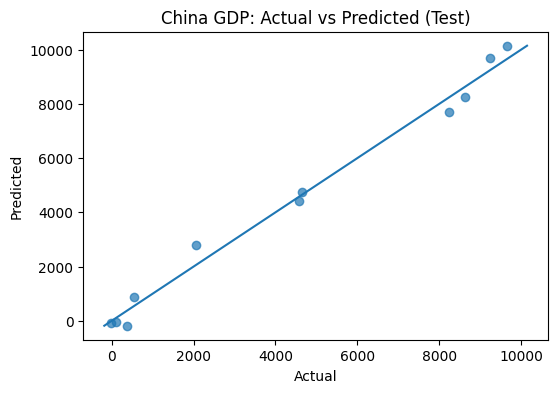

In [6]:

fname = "china_gdp.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    years = np.arange(1960, 2015)
    t = (years - 1960)/55.0
    gdp = 1e2 + 1e4 / (1 + np.exp(-10*(t-0.6))) + np.random.normal(0, 200, size=len(years))
    df = pd.DataFrame({"Year": years, "GDP": gdp})
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
if "Year" in data.columns and "GDP" in data.columns:
    X = data[["Year"]].values
    y = data["GDP"].values
else:
    X = data.iloc[:, [0]].values
    y = data.iloc[:, -1].values

poly = PolynomialFeatures(degree=4, include_bias=False)
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=RANDOM_STATE)
lr = LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

print_regression_metrics(y_test, pred)

X_full_poly = poly.transform(X)
y_full_pred = lr.predict(X_full_poly)
plt.figure()
plt.scatter(X.flatten(), y, s=12, label="Actual")
plt.plot(X.flatten(), y_full_pred, label="Model", linewidth=2)
plt.xlabel("Year")
plt.ylabel("GDP")
plt.title("China GDP: Polynomial Regression Fit")
plt.legend()
plt.show()

plot_actual_vs_pred(y_test, pred, title="China GDP: Actual vs Predicted (Test)")


## Q5) Logistic Regression – Cancer (Benign vs Malignant)

Accuracy: 0.94
Precision: 0.9038461538461539
Recall: 0.9791666666666666
F1-Score: 0.94


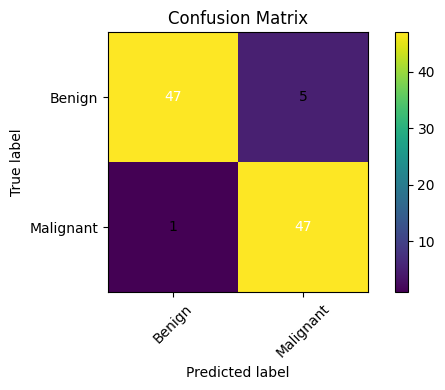

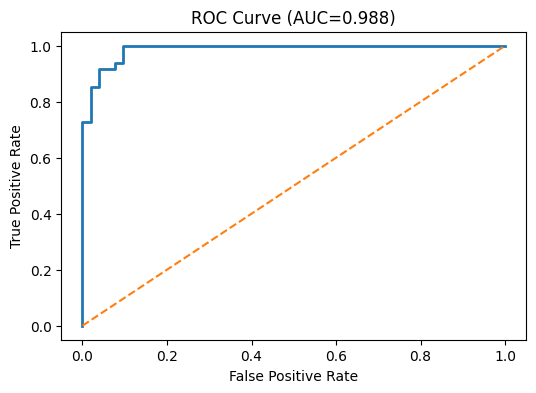

In [7]:

fname = "samples_cancer.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 400
    Xsyn = np.random.randn(n, 10)
    w = np.array([0.5, -1.2, 0.8, 0.3, -0.6, 1.1, -0.4, 0.9, 0.2, -0.7])
    logits = Xsyn @ w + np.random.normal(0, 0.5, size=n)
    ysyn = (logits > 0).astype(int)
    cols = [f"f{i}" for i in range(10)]
    df = pd.DataFrame(Xsyn, columns=cols)
    df["target"] = ysyn
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
ycol = "target" if "target" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(max_iter=2000)
lr.fit(X_train_s, y_train)
pred = lr.predict(X_test_s)
proba = lr.predict_proba(X_test_s)[:,1]

cm = confusion_matrix(y_test, pred)
print("Accuracy:", accuracy_score(y_test, pred))
print("Precision:", precision_score(y_test, pred))
print("Recall:", recall_score(y_test, pred))
print("F1-Score:", f1_score(y_test, pred))
plot_confusion_matrix_basic(cm, class_names=["Benign","Malignant"], title="Confusion Matrix")

fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={roc_auc:.3f})")
plt.show()


## Q6) KNN – Telecom Customer Category

In [8]:

fname = "teleCust.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 500
    Xsyn = np.random.randn(n, 5)
    ysyn = np.random.choice([0,1,2,3], size=n, p=[0.3,0.3,0.2,0.2])
    df = pd.DataFrame(Xsyn, columns=[f"f{i}" for i in range(5)])
    df["category"] = ysyn
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
ycol = "category" if "category" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_s, y_train)
pred = knn.predict(X_test_s)
print("Accuracy:", accuracy_score(y_test, pred))


Accuracy: 0.232


## Q7) Decision Tree – Drug Prediction (X/Y/C)

Accuracy: 0.35


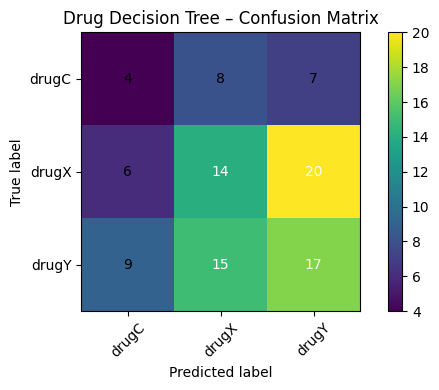

In [9]:

fname = "drug.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 400
    Xsyn = np.random.randn(n, 6)
    ysyn = np.random.choice(["drugX","drugY","drugC"], size=n, p=[0.4,0.4,0.2])
    cols = [f"f{i}" for i in range(6)]
    df = pd.DataFrame(Xsyn, columns=cols)
    df["drug"] = ysyn
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
ycol = "drug" if "drug" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, pred))

cm = confusion_matrix(y_test, pred, labels=np.unique(y))
plot_confusion_matrix_basic(cm, class_names=list(np.unique(y)), title="Drug Decision Tree – Confusion Matrix")


## Q8) Naive Bayes – Diabetes (GaussianNB & BernoulliNB)

In [10]:

fname = "pima-indians-diabetes.data.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 768
    Xsyn = np.abs(np.random.randn(n, 8))*5
    w = np.array([0.3,-0.7,1.1,0.2,-0.5,0.8,-1.0,0.6])
    logits = Xsyn @ w + np.random.normal(0, 1, size=n)
    ysyn = (logits > np.median(logits)).astype(int)
    df = pd.DataFrame(Xsyn, columns=[f"f{i}" for i in range(8)])
    df["Outcome"] = ysyn
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
ycol = "Outcome" if "Outcome" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

gnb = GaussianNB()
gnb.fit(X_train, y_train)
pred_g = gnb.predict(X_test)
print("GaussianNB – Accuracy:", accuracy_score(y_test, pred_g))
print("GaussianNB – F1:", f1_score(y_test, pred_g))

Xb_train = (X_train > np.median(X_train, axis=0)).astype(int)
Xb_test = (X_test > np.median(X_train, axis=0)).astype(int)
bnb = BernoulliNB()
bnb.fit(Xb_train, y_train)
pred_b = bnb.predict(Xb_test)
print("BernoulliNB – Accuracy:", accuracy_score(y_test, pred_b))
print("BernoulliNB – F1:", f1_score(y_test, pred_b))


GaussianNB – Accuracy: 0.9010416666666666
GaussianNB – F1: 0.9025641025641026
BernoulliNB – Accuracy: 0.7708333333333334
BernoulliNB – F1: 0.7684210526315789


## Q9) SVM – Cancer (Linear, Poly, RBF, Sigmoid) – Metrics & ROC

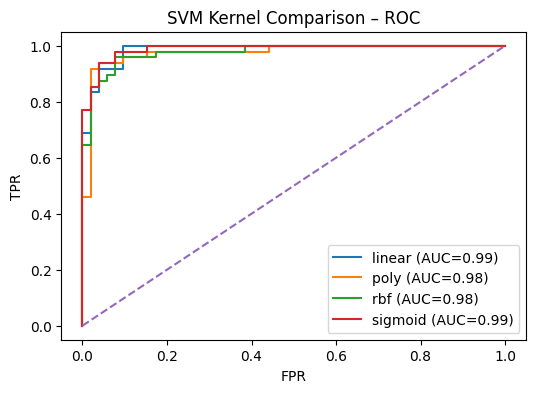


=== LINEAR ===
Accuracy: 0.93
Recall: 0.9583333333333334
Precision: 0.9019607843137255
F1-Score: 0.9292929292929293
Jaccard: 0.8679245283018868
Error rate: 0.06999999999999995


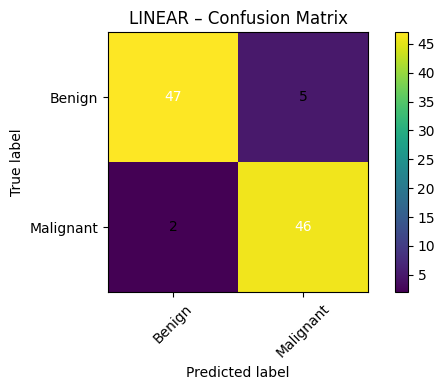


=== POLY ===
Accuracy: 0.9
Recall: 0.9583333333333334
Precision: 0.8518518518518519
F1-Score: 0.9019607843137255
Jaccard: 0.8214285714285714
Error rate: 0.09999999999999998


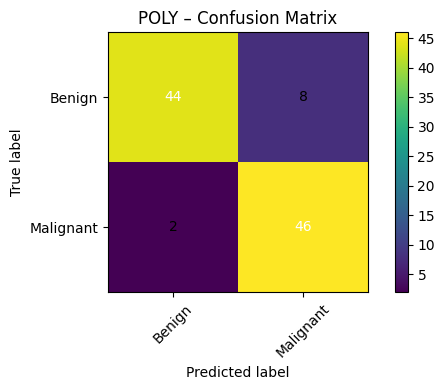


=== RBF ===
Accuracy: 0.93
Recall: 0.9583333333333334
Precision: 0.9019607843137255
F1-Score: 0.9292929292929293
Jaccard: 0.8679245283018868
Error rate: 0.06999999999999995


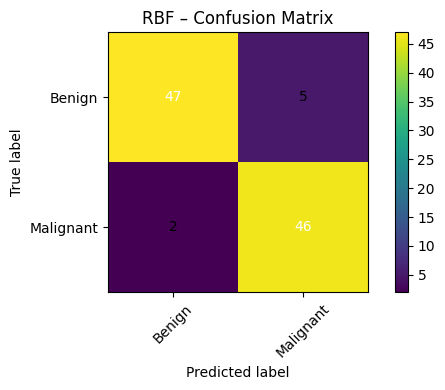


=== SIGMOID ===
Accuracy: 0.95
Recall: 0.9791666666666666
Precision: 0.9215686274509803
F1-Score: 0.9494949494949495
Jaccard: 0.9038461538461539
Error rate: 0.050000000000000044


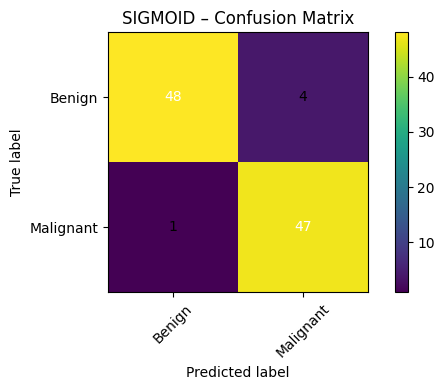

In [11]:

fname = "samples_cancer.csv"
data = pd.read_csv(fname)
ycol = "target" if "target" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

kernels = {
    "linear": {"kernel":"linear", "probability":True},
    "poly":   {"kernel":"poly", "degree":3, "probability":True},
    "rbf":    {"kernel":"rbf", "probability":True},
    "sigmoid":{"kernel":"sigmoid", "probability":True}
}

results = {}

plt.figure()
for name, params in kernels.items():
    clf = SVC(**params, random_state=RANDOM_STATE)
    clf.fit(X_train_s, y_train)
    pred = clf.predict(X_test_s)
    proba = clf.predict_proba(X_test_s)[:,1]

    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    jac = jaccard_score(y_test, pred)
    err = 1 - acc
    cm = confusion_matrix(y_test, pred)

    results[name] = {"acc":acc, "rec":rec, "prec":prec, "f1":f1, "jaccard":jac, "error":err, "cm":cm}

    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")

plt.plot([0,1],[0,1], linestyle="--")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("SVM Kernel Comparison – ROC")
plt.show()

for name, d in results.items():
    print(f"\n=== {name.upper()} ===")
    print("Accuracy:", d["acc"])
    print("Recall:", d["rec"])
    print("Precision:", d["prec"])
    print("F1-Score:", d["f1"])
    print("Jaccard:", d["jaccard"])
    print("Error rate:", d["error"])
    plot_confusion_matrix_basic(d["cm"], class_names=["Benign","Malignant"], title=f"{name.upper()} – Confusion Matrix")


## Q10) Diabetes – Compare SVM, Naive Bayes, Decision Tree, KNN (Metrics, Heatmap Confusion, ROC)


=== SVM (RBF) ===
Accuracy: 0.9479166666666666 Recall: 0.9166666666666666 Precision: 0.9777777777777777 F1: 0.946236559139785


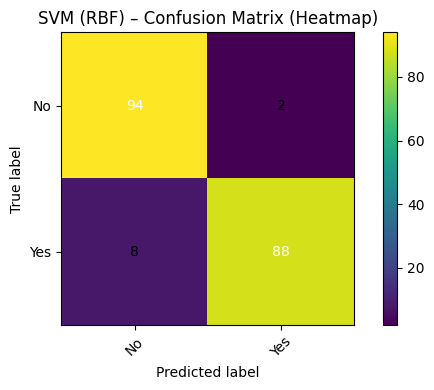


=== Naive Bayes ===
Accuracy: 0.9010416666666666 Recall: 0.9166666666666666 Precision: 0.8888888888888888 F1: 0.9025641025641026


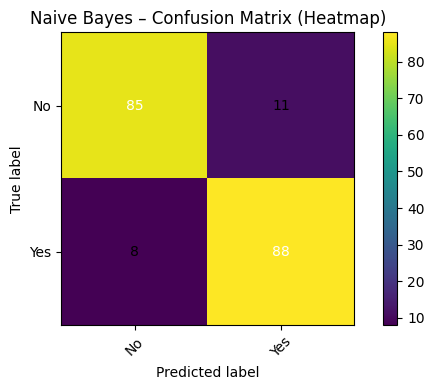


=== Decision Tree ===
Accuracy: 0.8177083333333334 Recall: 0.8020833333333334 Precision: 0.8279569892473119 F1: 0.8148148148148148


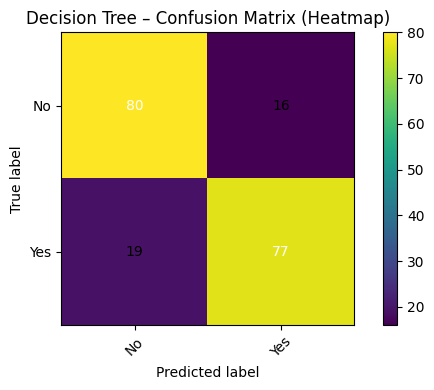


=== KNN (k=5) ===
Accuracy: 0.9114583333333334 Recall: 0.8958333333333334 Precision: 0.9247311827956989 F1: 0.91005291005291


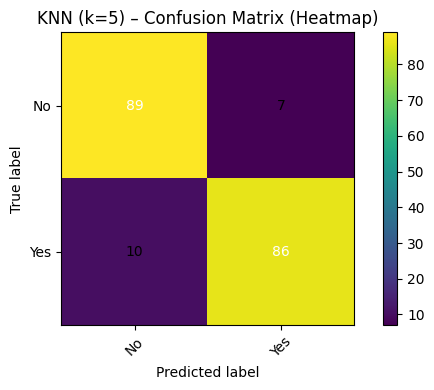

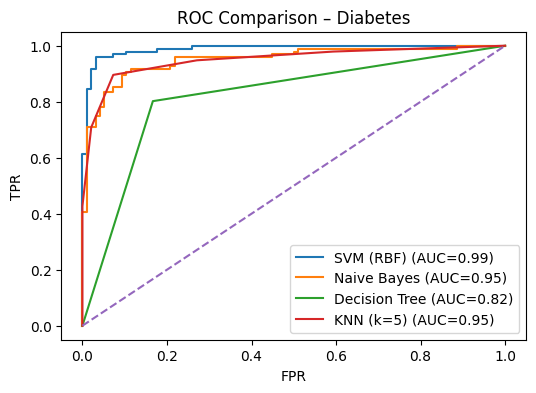

In [12]:

fname = "pima-indians-diabetes.data.csv"
data = pd.read_csv(fname)
ycol = "Outcome" if "Outcome" in data.columns else data.columns[-1]
X = data.drop(columns=[ycol]).values
y = data[ycol].values.astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

models = {
    "SVM (RBF)": SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5)
}

probas = {}
for name, model in models.items():
    if "SVM" in name or "KNN" in name:
        model.fit(X_train_s, y_train)
        pred = model.predict(X_test_s)
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(X_test_s)[:,1]
        else:
            proba = model.decision_function(X_test_s)
            proba = (proba - proba.min())/(proba.max()-proba.min()+1e-9)
    else:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        proba = model.predict_proba(X_test)[:,1]
    probas[name] = (pred, proba)

    acc = accuracy_score(y_test, pred)
    rec = recall_score(y_test, pred)
    prec = precision_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    print(f"\n=== {name} ===")
    print("Accuracy:", acc, "Recall:", rec, "Precision:", prec, "F1:", f1)

    cm = confusion_matrix(y_test, pred)
    plot_confusion_matrix_basic(cm, class_names=["No","Yes"], title=f"{name} – Confusion Matrix (Heatmap)")

plt.figure()
for name, (_, proba) in probas.items():
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.2f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Comparison – Diabetes")
plt.legend()
plt.show()


## Q11) Network of Perceptrons – XOR

Predictions on XOR: [1 0 1 0]
Accuracy: 0.5
Hidden weights shape(s): [(2, 2), (2, 1)]


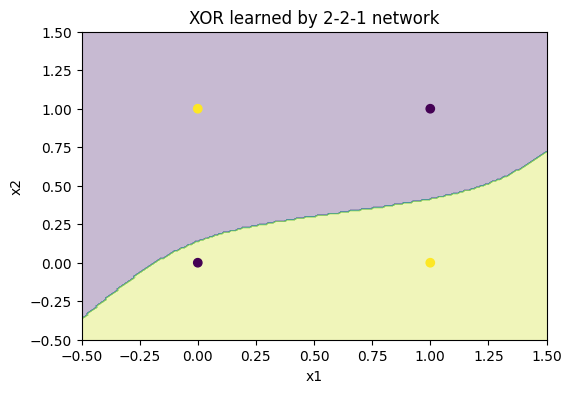

In [13]:

X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([0,1,1,0], dtype=int)

clf = MLPClassifier(hidden_layer_sizes=(2,), activation="tanh",
                    solver="sgd", learning_rate_init=0.1, max_iter=2000,
                    random_state=RANDOM_STATE)
clf.fit(X, y)
pred = clf.predict(X)

print("Predictions on XOR:", pred)
print("Accuracy:", accuracy_score(y, pred))
print("Hidden weights shape(s):", [w.shape for w in clf.coefs_])

xx, yy = np.meshgrid(np.linspace(-0.5, 1.5, 200), np.linspace(-0.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf.predict(grid).reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, zz, alpha=0.3)
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("XOR learned by 2-2-1 network")
plt.xlabel("x1"); plt.ylabel("x2")
plt.show()


## Q12) Multilayer Perceptron – Iris (activations & optimizers, metrics, weight/loss/accuracy curves)

C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(



Activation=logistic, Optimizer=sgd, Test Accuracy=0.921


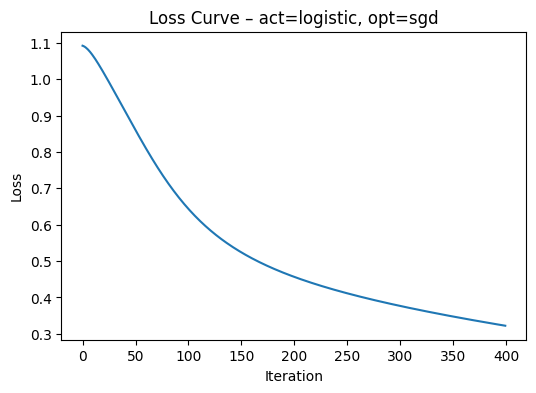

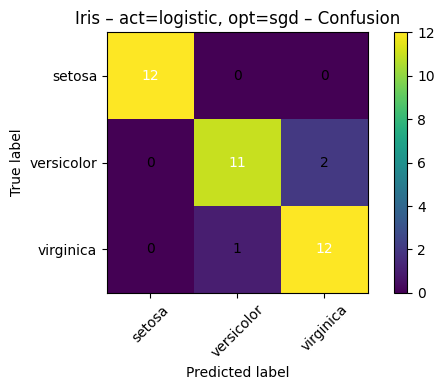

Layer weight shapes: [(4, 5), (5, 3)]


C:\Users\hp\AppData\Roaming\Python\Python313\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(



Activation=tanh, Optimizer=sgd, Test Accuracy=0.947


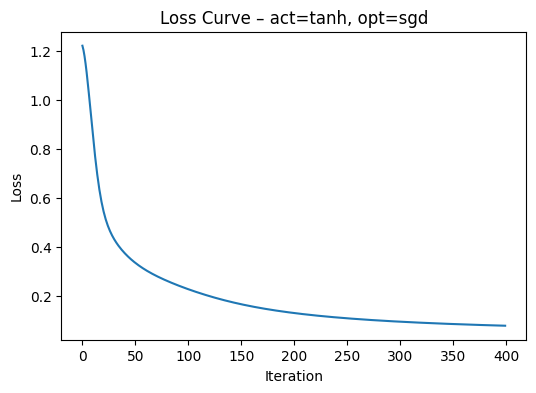

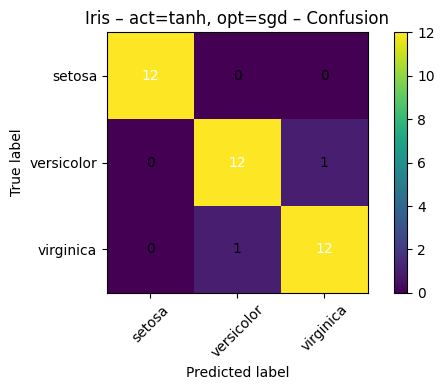

Layer weight shapes: [(4, 5), (5, 3)]

Activation=relu, Optimizer=adam, Test Accuracy=0.921


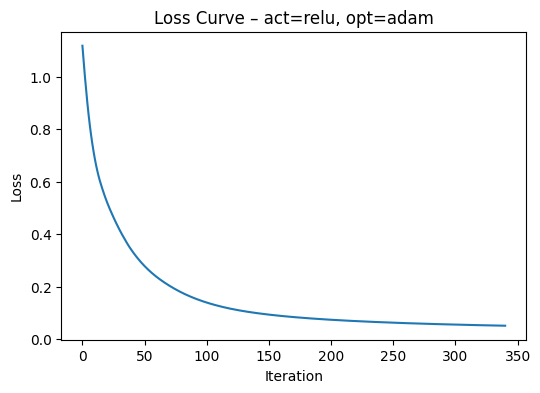

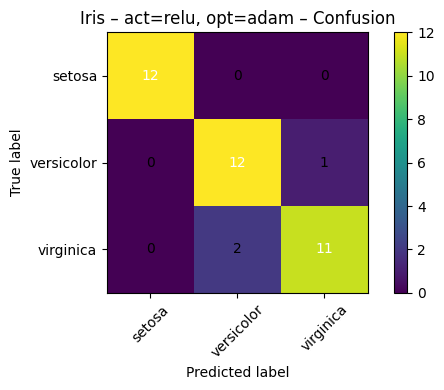

Layer weight shapes: [(4, 5), (5, 3)]


In [14]:

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

configs = [
    ("logistic", "sgd"),
    ("tanh", "sgd"),
    ("relu", "adam"),
]

for act, opt in configs:
    clf = MLPClassifier(hidden_layer_sizes=(5,), activation=act, solver=opt,
                        learning_rate_init=0.01, max_iter=400, random_state=RANDOM_STATE)
    clf.fit(X_train_s, y_train)
    pred = clf.predict(X_test_s)
    acc = accuracy_score(y_test, pred)
    print(f"\nActivation={act}, Optimizer={opt}, Test Accuracy={acc:.3f}")
    if hasattr(clf, "loss_curve_"):
        plt.figure()
        plt.plot(clf.loss_curve_)
        plt.title(f"Loss Curve – act={act}, opt={opt}")
        plt.xlabel("Iteration"); plt.ylabel("Loss")
        plt.show()

    cm = confusion_matrix(y_test, pred)
    plot_confusion_matrix_basic(cm, class_names=list(iris.target_names), title=f"Iris – act={act}, opt={opt} – Confusion")
    print("Layer weight shapes:", [w.shape for w in clf.coefs_])


## Q13) K-means Clustering – Customer Segmentation (Euclidean & Manhattan)

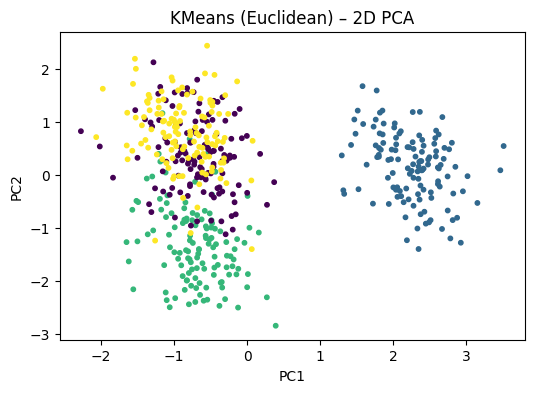

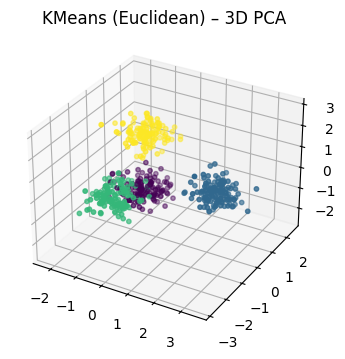

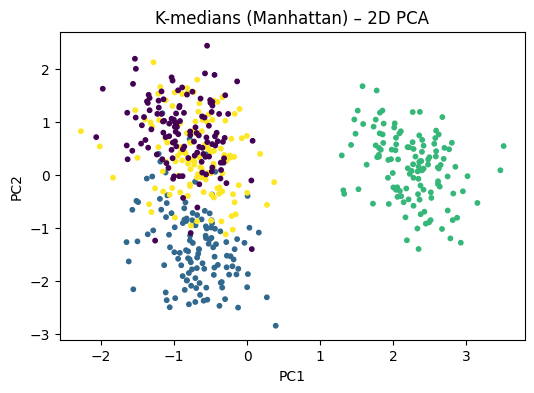

In [16]:

fname = "Customer segmentation dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n_per = 125
    centers = np.array([[0,0,0,0,0],[5,5,0,0,0],[0,5,5,0,0],[5,0,5,5,0]])
    Xsyn = np.vstack([c + np.random.randn(n_per, 5) for c in centers])
    df = pd.DataFrame(Xsyn, columns=[f"f{i}" for i in range(5)])
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

k = 4
kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
labels_euc = kmeans.fit_predict(Xs)

p2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
plt.figure()
plt.scatter(p2[:,0], p2[:,1], c=labels_euc, s=10)
plt.title("KMeans (Euclidean) – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

p3 = PCA(n_components=3, random_state=RANDOM_STATE).fit_transform(Xs)
from mpl_toolkits.mplot3d import Axes3D  # noqa
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p3[:,0], p3[:,1], p3[:,2], c=labels_euc, s=10)
ax.set_title("KMeans (Euclidean) – 3D PCA")
plt.show()

def manhattan_distance(a, b):
    return np.abs(a-b).sum(axis=1)

rng = np.random.RandomState(RANDOM_STATE)
med_idx = rng.choice(len(Xs), size=k, replace=False)
medians = Xs[med_idx].copy()

for _ in range(20):
    dists = np.stack([manhattan_distance(Xs, m) for m in medians], axis=1)
    labels = dists.argmin(axis=1)
    new_medians = []
    for j in range(k):
        cluster_pts = Xs[labels==j]
        if len(cluster_pts)==0:
            new_medians.append(medians[j])
        else:
            new_medians.append(np.median(cluster_pts, axis=0))
    new_medians = np.array(new_medians)
    if np.allclose(new_medians, medians):
        break
    medians = new_medians

labels_manh = labels

plt.figure()
plt.scatter(p2[:,0], p2[:,1], c=labels_manh, s=10)
plt.title("K-medians (Manhattan) – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


## Q14) Hierarchical Clustering – Agglomerative & Divisive (with Dendrogram)

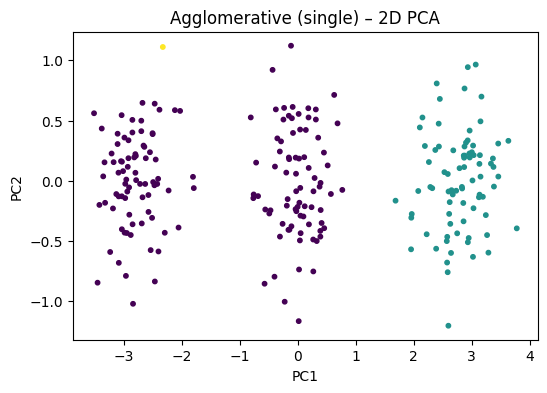

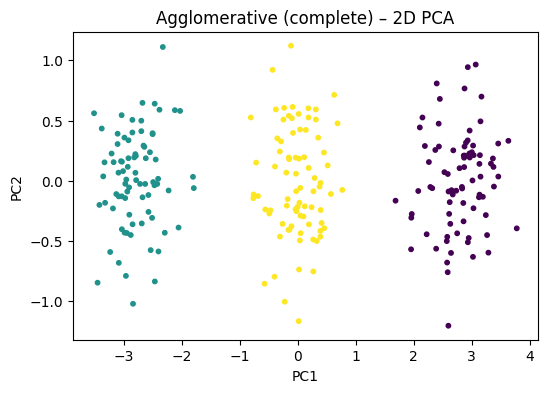

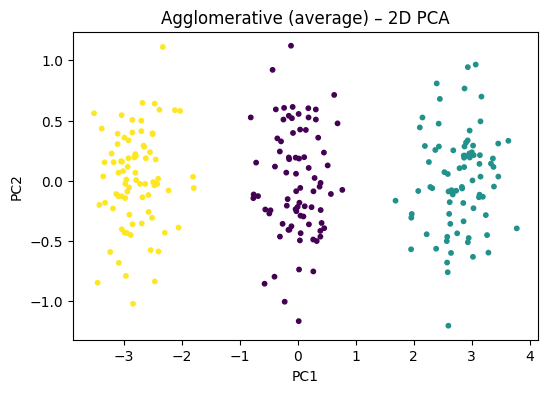

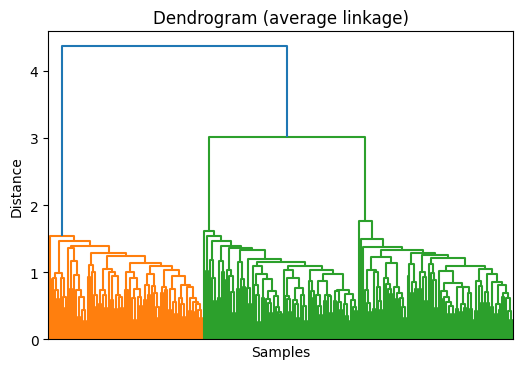

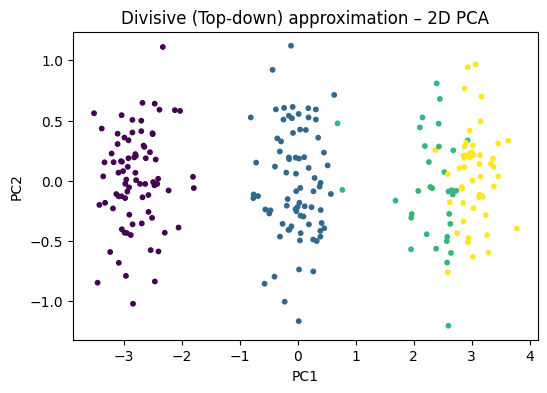

In [17]:

fname = "Vehicle dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n = 240
    Xsyn = np.vstack([np.random.randn(80,6)+i for i in [0,3,6]])
    df = pd.DataFrame(Xsyn, columns=[f"f{i}" for i in range(6)])
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

for lk in ["single", "complete", "average"]:
    agg = AgglomerativeClustering(n_clusters=3, linkage=lk)
    labels = agg.fit_predict(Xs)
    p2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    plt.figure()
    plt.scatter(p2[:,0], p2[:,1], c=labels, s=10)
    plt.title(f"Agglomerative ({lk}) – 2D PCA")
    plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

if SCIPY_OK:
    from scipy.cluster.hierarchy import linkage, dendrogram
    Z = linkage(Xs, method="average")
    plt.figure()
    dendrogram(Z, no_labels=True, count_sort=True)
    plt.title("Dendrogram (average linkage)")
    plt.xlabel("Samples"); plt.ylabel("Distance")
    plt.show()
else:
    print("SciPy not available – skipping dendrogram plot. (Install scipy to enable.)")

def divisive_clustering(Xs, max_depth=3):
    clusters = [np.arange(len(Xs))]
    for depth in range(max_depth):
        sizes = [len(c) for c in clusters]
        idx = int(np.argmax(sizes))
        big = clusters.pop(idx)
        if len(big) < 2:
            clusters.insert(idx, big)
            break
        km = KMeans(n_clusters=2, random_state=RANDOM_STATE, n_init=10)
        labels = km.fit_predict(Xs[big])
        c0 = big[labels==0]
        c1 = big[labels==1]
        clusters.extend([c0, c1])
    return clusters

clusters = divisive_clustering(Xs, max_depth=3)
labels_div = np.zeros(len(Xs), dtype=int)
for i, c in enumerate(clusters):
    labels_div[c] = i

p2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
plt.figure()
plt.scatter(p2[:,0], p2[:,1], c=labels_div, s=10)
plt.title("Divisive (Top-down) approximation – 2D PCA")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()


## Q15) DBSCAN – Weather Station Clustering (with Outliers)

Number of outliers: 24


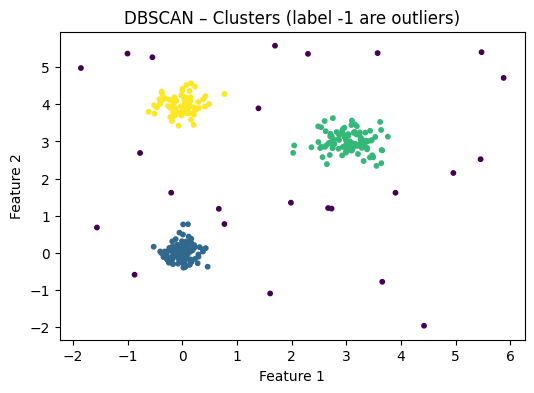

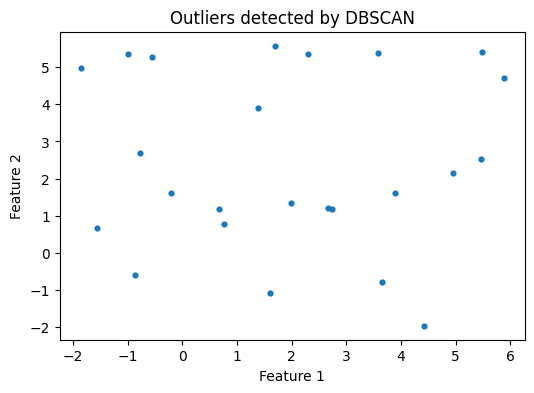

In [18]:

fname = "Weather Station dataset.csv"
if not os.path.exists(fname):
    np.random.seed(RANDOM_STATE)
    n1 = 120; n2 = 100; n3 = 80
    c1 = np.random.randn(n1, 2)*0.2 + np.array([0,0])
    c2 = np.random.randn(n2, 2)*0.3 + np.array([3,3])
    c3 = np.random.randn(n3, 2)*0.25 + np.array([0,4])
    noise = np.random.uniform(low=-2, high=6, size=(30,2))
    Xsyn = np.vstack([c1,c2,c3,noise])
    df = pd.DataFrame(Xsyn, columns=["x","y"])
    df = ensure_csv_or_make(df, fname)

data = pd.read_csv(fname)
X = data.select_dtypes(include=[np.number]).values

scaler = StandardScaler()
Xs = scaler.fit_transform(X)

db = DBSCAN(eps=0.3, min_samples=5)
labels = db.fit_predict(Xs)

outliers = labels == -1
n_out = outliers.sum()
print("Number of outliers:", n_out)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=labels, s=10)
plt.title("DBSCAN – Clusters (label -1 are outliers)")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.show()

plt.figure()
plt.scatter(X[outliers,0], X[outliers,1], s=12)
plt.title("Outliers detected by DBSCAN")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.show()
